In [188]:
import yaml
import pandas as pd
import numpy as np
import re
from bokeh.plotting import output_notebook, figure
import seaborn as sns
import hvplot.pandas
import matplotlib.pyplot as plt

output_notebook()

Loading BokehJS ...

## 2. Data acquisition

The data used in this project is obtained from two different data sources. The BMI data is obtained from https://www.ncdrisc.org/data-downloads-adiposity.html and downloaded in the csv format. This data contains out of all of the mean BMI's (with 95% confidence intervals) per country per sex, ranging from the year 1975 to 2016. In addition, the dataset contains the prevalence of certain BMI ranges (with 95% confidence intervals). For example, a person is classified as obese if the BMI is higher or equal to 30.

The affordability of a healthy diet is obtained from https://databank.worldbank.org/source/food-prices-for-nutrition (select all under country, select 'Affordability of a healthy diet: ratio of cost to food expenditures' under series, select 2017 under year) and downloaded in the csv format. In this dataset the affordability of a healthy diet is defined as the ratio of the cost of a healthy diet to food expenditures. This ratio is given by country and by sex in the year 2017.

Keep in mind that the BMI dataset is from the year 2017 and the healthy diet affordability dataset is from 2016. At this point in time the global BMI data is only available up to 2016 and the healthy diet data from 2017 until 2020. In this project the 2017 and 2016 will be compared. The mean BMI and heatlhy diet affordability are unlikely to change a lot from year to year and therefor are compared. However, when 2017 BMI data is available it is better to use that instead of the 2016 data.

## 3. Loading and cleaning the data

The dataset are loaded into a pandas dataframe using a config file

In [ ]:
# load the datafiles using a config files
with open("./config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

bmi = config['bmi']
healthy_diet_affordability = config['food_affordability']

: 

### 3.1 BMI

In [ ]:
df_bmi = pd.read_csv(bmi, encoding='latin-1') # file uses latin-1 encoding
df_bmi = df_bmi.astype({'Country/Region/World': str, 'ISO': str})
df_bmi = df_bmi[df_bmi.Year == 2016]  # we only want the 2016 data
df_bmi = df_bmi.drop(columns='Year')  # remove the year column, we only have 2016 left so redundant
df_bmi.head()
df_bmi.dtypes

Country/Region/World                                                         object
ISO                                                                          object
Sex                                                                          object
Mean BMI                                                                    float64
Mean BMI lower 95% uncertainty interval                                     float64
Mean BMI upper 95% uncertainty interval                                     float64
Prevalence of BMI>=30 kg/m² (obesity)                                       float64
Prevalence of BMI>=30 kg/m² lower 95% uncertainty interval                  float64
Prevalence of BMI>=30 kg/m² upper 95% uncertainty interval                  float64
Prevalence of BMI>=35 kg/m² (severe obesity)                                float64
Prevalence of BMI>=35 kg/m² lower 95% uncertainty interval                  float64
Prevalence of BMI>=35 kg/m² upper 95% uncertainty interval                  

: 

Some column names are pretty long and make it inconvenient to read and work with. The next code chunk shortens these column names to make it more readible. This is done by regex and substituting some words into shorter words or removing parts of the column name.

In [ ]:
# dict for patterns and replacements for the column names
replace_dict = {'Prevalence': 'Prev', 'kg/m²': '', 'lower 95% uncertainty interval': 'lower', 'upper 95% uncertainty interval': 'upper'}
for pattern, replacement in replace_dict.items():
    df_bmi = df_bmi.rename(columns=lambda column: re.sub(pattern, replacement, column))  # loops trhough all of the columns and use re.sub for the replacement
    

: 

In [ ]:
df_bmi.head()

,Country/Region/World,ISO,Sex,Mean BMI,Mean BMI lower,Mean BMI upper,Prev of BMI>=30 (obesity),Prev of BMI>=30 lower,Prev of BMI>=30 upper,Prev of BMI>=35 (severe obesity),...,Prev of BMI 25 to <30 upper,Prev of BMI 30 to <35,Prev of BMI 30 to <35 lower,Prev of BMI 30 to <35 upper,Prev of BMI 35 to <40,Prev of BMI 35 to <40 lower,Prev of BMI 35 to <40 upper,Prev of BMI >=40 (morbid obesity),Prev of BMI >=40 lower,Prev of BMI >=40 upper
41,Afghanistan,AFG,Men,22.682456,20.157475,25.241857,0.033603,0.013884,0.066334,0.003314,...,0.242503,0.030290,0.011207,0.062681,0.002271,0.000310,0.007487,0.001043,0.000074,0.004265
83,Albania,ALB,Men,27.174471,25.975170,28.338256,0.223735,0.153334,0.300834,0.045036,...,0.515957,0.178699,0.113401,0.252200,0.037684,0.013616,0.076984,0.007352,0.001180,0.021953
125,Algeria,DZA,Men,24.865386,23.487321,26.220294,0.206662,0.141854,0.279979,0.042840,...,0.463570,0.163822,0.102610,0.234048,0.031750,0.011066,0.065164,0.011090,0.002289,0.029802
167,American Samoa,ASM,Men,33.066721,31.338678,34.662447,0.587546,0.502606,0.666355,0.322678,...,0.370043,0.264868,0.191211,0.340031,0.183871,0.109862,0.263723,0.138807,0.067651,0.223666
209,Andorra,AND,Men,27.478395,24.988831,30.001977,0.267498,0.186223,0.354723,0.068565,...,0.532478,0.198934,0.125035,0.280761,0.052701,0.017627,0.109639,0.015864,0.002652,0.046309


: 

### 3.2 Affordability of a healthy diet

In [ ]:
df_healthy_diet = pd.read_csv(healthy_diet_affordability, encoding='latin-1', skipfooter=5, engine='python')  # skip last lines, does not contain data
df_healthy_diet.drop(columns=['Classification Name', 'Classification Code', 'Time', 'Time Code'], inplace=True)  # irrelevant columns
df_healthy_diet.rename(columns={'Affordability of a healthy diet: ratio of cost to food expenditures [CoHD_fexp]': 'Affordability of a healthy diet'}, inplace=True)
df_healthy_diet['Affordability of a healthy diet'] = df_healthy_diet['Affordability of a healthy diet'].replace('..', np.nan)
df_healthy_diet = df_healthy_diet.astype({'Affordability of a healthy diet': float})

: 

In [ ]:
df_healthy_diet.head()
df_healthy_diet.dtypes

Country Name                        object
Country Code                        object
Affordability of a healthy diet    float64
dtype: object

: 

## 4. Data exploration

Before the data exploration a decision must be made wether or not the data should be merged already. This is done by seeing if there are differences in countries used in the datasets. The reasoning behind this is that he country variable the variable is on which the datasets are merged. If some countries are not shared between the datasets, the data will be omitted.

In [ ]:
countries_bmi = df_bmi['ISO'].unique()
countries_healthy_diet = df_healthy_diet['Country Code'].unique()
countries_not_in_common = set(countries_bmi) ^ set(countries_healthy_diet)  # check which values are not shared
print(f'countries not in common:\n {countries_not_in_common}\n')
print(f'amount: {len(countries_not_in_common)}')

countries not in common:
 {'TLS', 'VEN', 'NIU', 'AND', 'LCN', 'SXM', 'LIC', 'SLB', 'TON', 'TCA', 'COK', 'LBY', 'GTM', 'UKR', 'PLW', 'VUT', 'WSM', 'LMC', 'GRL', 'UZB', 'ERI', 'TUV', 'FSM', 'EAS', 'AIA', 'PRK', 'WLD', 'PNG', 'ECS', 'GEO', 'MSR', 'VGB', 'HIC', 'SYR', 'LBN', 'NRU', 'PYF', 'CYM', 'ASM', 'MEA', 'BON', 'NAC', 'UMC', 'MHL', 'ABW', 'CUB', 'TKL', 'SAS', 'SSF', 'AFG', 'CUW', 'SOM', 'YEM', 'PRI', 'KIR', 'TKM'}

amount: 56


: 

As can be seen above there are a lot of countries (56) which are not in common between both datasets. When merging these datasets (using inner merge) this data gets lost. Therefore it makes sense to merge the datasets before data exploration, because otherwise data exploration is done on data which is later omitted.

In [230]:
df_merged = df_healthy_diet.merge(right=df_bmi, 
                                  left_on='Country Code',
                                  right_on='ISO',
                                  how='inner')
df_merged.drop(columns=['Country/Region/World', 'ISO'], inplace=True)  # duplicate columns that can be deleted
df_merged.head()

,Country Name,Country Code,Affordability of a healthy diet,Sex,Mean BMI,Mean BMI lower 95% uncertainty interval,Mean BMI upper 95% uncertainty interval,Prevalence of BMI>=30 kg/m² (obesity),Prevalence of BMI>=30 kg/m² lower 95% uncertainty interval,Prevalence of BMI>=30 kg/m² upper 95% uncertainty interval,...,Prevalence of BMI 25 kg/m² to <30 kg/m² upper 95% uncertainty interval,Prevalence of BMI 30 kg/m² to <35 kg/m²,Prevalence of BMI 30 kg/m² to <35 kg/m² lower 95% uncertainty interval,Prevalence of BMI 30 kg/m² to <35 kg/m² upper 95% uncertainty interval,Prevalence of BMI 35 kg/m² to <40 kg/m²,Prevalence of BMI 35 kg/m² to <40 kg/m² lower 95% uncertainty interval,Prevalence of BMI 35 kg/m² to <40 kg/m² upper 95% uncertainty interval,Prevalence of BMI >=40 kg/m²(morbid obesity),Prevalence of BMI >=40 kg/m² lower 95% uncertainty interval,Prevalence of BMI >=40 kg/m² upper 95% uncertainty interval
0,Albania,ALB,0.425,Men,27.174471,25.975170,28.338256,0.223735,0.153334,0.300834,...,0.515957,0.178699,0.113401,0.252200,0.037684,0.013616,0.076984,0.007352,0.001180,0.021953
1,Albania,ALB,0.425,Women,26.507512,25.196840,27.859854,0.227215,0.160322,0.300595,...,0.365555,0.154878,0.096033,0.225306,0.054146,0.022398,0.100402,0.018191,0.004656,0.044692
2,Algeria,DZA,0.605,Men,24.865386,23.487321,26.220294,0.206662,0.141854,0.279979,...,0.463570,0.163822,0.102610,0.234048,0.031750,0.011066,0.065164,0.011090,0.002289,0.029802
3,Algeria,DZA,0.605,Women,26.561166,25.080506,28.031641,0.362187,0.287831,0.440170,...,0.383587,0.225826,0.155871,0.303311,0.093082,0.047469,0.152826,0.043279,0.015501,0.089878
4,Angola,AGO,0.972,Men,22.436538,19.732903,25.172488,0.042276,0.016349,0.081935,...,0.237444,0.035127,0.011140,0.073699,0.005868,0.000739,0.018757,0.001281,0.000033,0.006267


In [194]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 0 to 329
Data columns (total 34 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   Country Name                                                              330 non-null    object 
 1   Country Code                                                              330 non-null    object 
 2   Affordability of a healthy diet                                           322 non-null    float64
 3   Sex                                                                       330 non-null    object 
 4   Mean BMI                                                                  330 non-null    float64
 5   Mean BMI lower 95% uncertainty interval                                   330 non-null    float64
 6   Mean BMI upper 95% uncertainty interval                           

We have 330 entries left after merging. If correct, each country should have BMI data about both sexes. So data of a total of $330 / 2 = 165$  countries are available. This is checked in the following code chunk 

In [195]:
df_merged['Country Name'].nunique()

165

This confirms that the dataset indeed holds data of 165 countries.

When looking at the 'Affordability of a healthy diet' data, we should select only one gender. This is because the data of 'Affordability of a healthy diet' is available per country. This data is simply the same per sex per country. To confirm this, the descriptive statistics can be compared

In [196]:
df_merged[df_merged['Sex'] == 'Men']['Affordability of a healthy diet'].describe() == df_merged[df_merged['Sex'] == 'Women']['Affordability of a healthy diet'].describe()

count    True
mean     True
std      True
min      True
25%      True
50%      True
75%      True
max      True
Name: Affordability of a healthy diet, dtype: bool

This confirms that they are the same. We can now select one gender when looking at this data

In [197]:
df_merged[df_merged['Sex'] == 'Men']['Affordability of a healthy diet'].describe()

count    161.000000
mean       0.818025
std        0.679886
min        0.247000
25%        0.391000
50%        0.640000
75%        0.972000
max        5.272000
Name: Affordability of a healthy diet, dtype: float64

The first thing that is noticebly is that there are 161 entries, while we have 165 countries. This is probably due to missing values. Additionaly, a high standard deviation can be observed. The max value is also hihg compared the 75% value. This means that here are probably outliers.


In [198]:
df_merged[df_merged['Sex'] == 'Men']['Affordability of a healthy diet'].isna().sum()

4

There are indeed missing data for four countries. Since this data cannot be used in our data analysis later on, we should omit it from this dataset.

In [231]:
df_merged = df_merged[df_merged['Affordability of a healthy diet'].notna()]
df_merged[df_merged['Sex'] == 'Men']['Affordability of a healthy diet'].isna().sum()

0

The rows with missing values in the 'Affordability of a healthy diet have been succesfully removed. Since the descriptive statistics show a a large distribtuion it might be good to look at the distribution of the data visually using a boxplot.

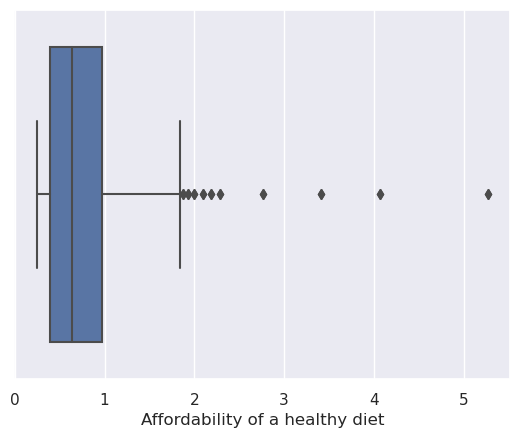

In [232]:
sns.set(style="darkgrid")  # add grids to plot
sns.boxplot(x=df_merged['Affordability of a healthy diet'])# title='Test')
# sns.title('Boxplot of mean BMI per sex')
plt.show()

As expected there are a lot of outliers in the upper range. this means that in certain countries the healthy diet is very unaffordable. To get an insight into the reason, we can look at these countries.

In [233]:
stats = df_merged[df_merged['Sex'] == 'Men']['Affordability of a healthy diet'].describe()
q1 = stats[4]
q3 = stats[6]
iqr = q3 - q1
upper_value = q3 + 1.5 * iqr

df_merged[df_merged['Affordability of a healthy diet'] > upper_value]['Country Name'].unique()

array(['Burkina Faso', 'Burundi', 'Central African Republic',
       'Congo, Dem. Rep.', 'Ethiopia', 'Ghana', 'Liberia', 'Malawi',
       'Mozambique', 'Niger'], dtype=object)

These are all poor countries in Africa. Since there is a lot of poverty in Africa, it makes sense that a healthy diet is also very unaffordable, just like all the other food. The same problem may also occur in other poor countries outside africa. Because of this reason and the intention of this project the decision is made to only include countries located in Europe. To do this, a table is found in where it list all of the countries and there 3 letter codes and there corresponding continent. The table is obtained from: https://gist.githubusercontent.com/stevewithington/20a69c0b6d2ff846ea5d35e5fc47f26c/raw/13716ceb2f22b5643ce5e7039643c86a0e0c6da6/country-and-continent-codes-list-csv.csv. 

In [234]:
df_countries = pd.read_csv('https://gist.githubusercontent.com/stevewithington/20a69c0b6d2ff846ea5d35e5fc47f26c/raw/13716ceb2f22b5643ce5e7039643c86a0e0c6da6/country-and-continent-codes-list-csv.csv')
df_countries.head()

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4.0
1,Europe,EU,"Albania, Republic of",AL,ALB,8.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12.0
4,Oceania,OC,American Samoa,AS,ASM,16.0


In [238]:
contries_eu = df_countries[df_countries['Continent_Name'] == 'Europe']['Three_Letter_Country_Code']
df_merged = df_merged[df_merged['Country Code'].isin(contries_eu)]

In [239]:
df_merged['Country Name'].nunique()

43

There are 43 countries left after selecting European countries. We can again have a look at the distribution of the data, descriptive and graphically.

In [241]:
df_merged['Affordability of a healthy diet'].describe()

count    86.000000
mean      0.384070
std       0.081929
min       0.247000
25%       0.335000
50%       0.378000
75%       0.432500
max       0.608000
Name: Affordability of a healthy diet, dtype: float64

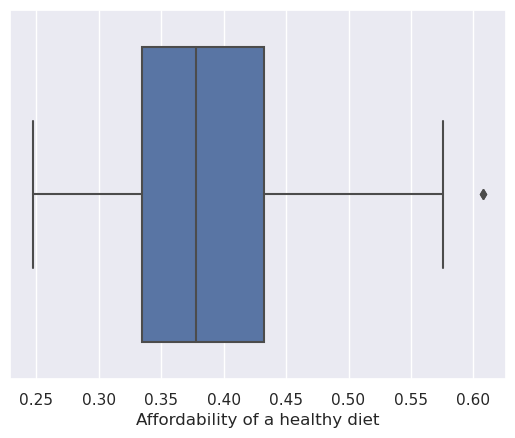

In [242]:
sns.set(style="darkgrid")  # add grids to plot
sns.boxplot(x=df_merged['Affordability of a healthy diet'])# title='Test')
# sns.title('Boxplot of mean BMI per sex')
plt.show()

The distribution of the data is now better. There is an outliers, which is not removed. This is because ....

The BMI data can also be explored:

In [251]:
df_merged['Mean BMI'].describe()

count    86.000000
mean     26.614409
std       0.947460
min      23.818752
25%      26.062499
50%      26.669177
75%      27.201321
max      28.942234
Name: Mean BMI, dtype: float64

As can be seen the mean BMI in the world using the available data is approximately 26.6. At a BMI higher or equal to 25 a person is classified as 'overweight'. This means that the mean of the population is overweight. The standard deviation and quartiles look nicely distributed

In [254]:
boxplot = df_merged.hvplot.box(y='Mean BMI',
                               by='Sex',
                               width=500,
                               height=500,
                               title='Boxplot of BMI per Sex',
                               color='Sex',
                               cmap=['dodgerblue', 'violet'],
                               legend=False)
# print(help(pd.DataFrame.hvplot.box))
boxplot
# sns.set(style="darkgrid")  # add grids to plot
# sns.boxplot(x='Mean BMI', y='Sex', data=df_merged,
#                           palette={'Men': 'dodgerblue', 'Women': 'violet'})
# sns.title('Boxplot of mean BMI per sex')
# plt.show()

:BoxWhisker   [Sex]   (Mean BMI)

As visualised above, the Mean BMI data shows a nice distribution for both genders. Neither men nor women show outliers. The data of men is a bit higher in all quartiles, and therefor also has a higher median. The women data has a higher variance compared to men.

## 5. Statistical analysis

For the statistical analysis the relationship between BMI and the affordability of a healthy diet is analysed. To get a graphical overview, both data are plotted on a map to see if there is visually a noticebly difference.

In [279]:
import geopandas as gpd

AttributeError: partially initialized module 'fiona' has no attribute '_loading' (most likely due to a circular import)

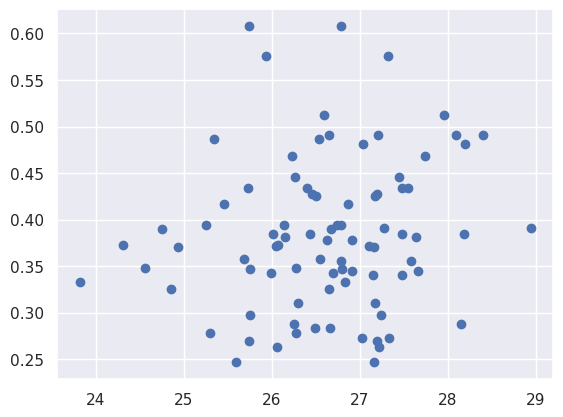

In [258]:
plt.plot(df_merged['Mean BMI'], df_merged['Affordability of a healthy diet'], 'o')
plt.show()